In [1]:
import os
import sys
sys.path.append("..")
import prototypes
from primitives import *
from agent import DummyAgent

import nxsdk.api.n2a as nx
import numpy as np
from nxsdk.graph.monitor.probes import *

In this example, we build and test a block to demonstrate how an operation can be built up using the ProcessNodes framework. Here, the computation is taking a one-hot 'state' spike vector, and combining it with a one-hot 'action' vector to build the outer product and compute the current state-action pair. 

This computation can be done by hand, but here the nodes framework automatically computes the number of compartments required and generates the appropriate connectivity matrix to give the correct answer. In this way, if the number of actions or states changes, the compartments and connections are updated when the network is compiled. 

In [2]:
n_states = 5
n_actions = 3
n_estimates = n_states * n_actions
shape = (n_actions, n_states)
time = n_estimates+1

In [3]:
agent = DummyAgent(n_actions, n_states)
net = agent.network

Here, we create the incoming spike and action signals. In this test case, they are timed spikes generated beforehand.

In [4]:
state = net.createSpikeGenProcess(numPorts = n_states)
action = net.createSpikeGenProcess(numPorts = n_actions)

In [5]:
#create a spike for each state/action pair
def create_spikes(state_gen, action_gen, time):
    n_states = state_gen.numPorts
    n_actions = action_gen.numPorts
    
    state_signals = [[] for i in range(n_states)]
    action_signals = [[] for i in range(n_actions)]
    
    for t in range(time-1):
        state_port = t % n_states
        action_port = t // n_states
        
        state_signals[state_port].append(t+1)
        action_signals[action_port].append(t+1)
        
    [state_gen.addSpikes([i], [state_signals[i]]) for i in range(n_states)]
    [action_gen.addSpikes([i], [action_signals[i]]) for i in range(n_actions)]

In [6]:
create_spikes(state, action, time)

Now, the node to carry out the and operation is created in one line by calling pre-defined prototypes. 

In [7]:
and_op = AndNode(net, shape)

Finally, the nodes of the graph are connected by calling the appropriate connection method. In this case, because the operation is an outer product of two vectors, we can use the dense_along_axis method to densely connect the appropriate source along its matching axis.

In the call below, the spike generator for the actions is connected along its 0th (only) axis to the and node's matching 0th axis using the and node's synaptic prototype. Nodes may require specific synapses to operate correctly, and here it is accessed by calling its member get_synproto() method.

In [8]:
action_conn = dense_along_axis(action, (n_actions,1), 0,
                              and_op.get_inputs(), and_op.shape, 0,
                             and_op.get_synproto())

Now, the same is done for the state spike generator. The only difference is it is connected along the and node's 1st axis, which matches its shape, forming the product.

In [9]:
state_conn = dense_along_axis(state, (n_states,1), 0,
                              and_op.get_inputs(), and_op.shape, 1,
                             and_op.get_synproto())

In [10]:
output = and_op.get_outputs()
out_spikes = output.probe(nx.ProbeParameter.SPIKE)

In [11]:
net.run(time)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37079
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Compiling Embedded snips....Done 0.30s
INFO:DRV:      Encoding axons/synapses.....Done 3.20ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599605672.3825424/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.03s
INFO:DRV:      Encoding probes.............Done 0.81ms
INFO:DRV:      Transferring probes.........Done 3.52ms
INFO:DRV:      Configuring registers.......Done 4.58ms
INFO:DRV:      Transferring spikes.........Done 3.14ms
INFO:DRV:      Executing...................Done 2.65ms
INFO:DRV:      Processing timeseries.......Done 2.90ms
INFO:DRV:  Executor: 16 timesteps..........Done 2.56s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


Now, we can inspect the output and show that indeed, one unique spike is generated for each state-action pair which is encountered in the input.

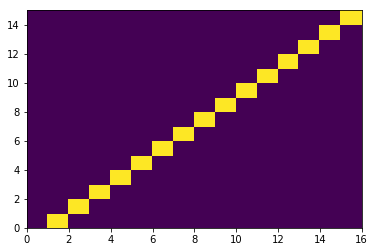

In [12]:
plt.pcolor(out_spikes[0].data)

To demonstrate the flexibility of the system, we can combine everything into one function and show it can automatically generate the desired network while using flexible, readable code.

In [13]:
def test_and_net(n_states, n_actions):
    #set parameters
    n_estimates = n_states * n_actions
    shape = (n_actions, n_states)
    time = n_estimates+1
    
    #construct the network
    agent = DummyAgent(n_actions, n_states)
    net = agent.network
    
    state = net.createSpikeGenProcess(numPorts = n_states)
    action = net.createSpikeGenProcess(numPorts = n_actions)
    create_spikes(state, action, time)
    
    and_op = AndNode(net, shape)
    
    action_conn = dense_along_axis(action, (n_actions,1), 0,
                              and_op.get_inputs(), and_op.shape, 0,
                             and_op.get_synproto())
    
    state_conn = dense_along_axis(state, (n_states,1), 0,
                              and_op.get_inputs(), and_op.shape, 1,
                             and_op.get_synproto())
    
    #define outputs & test
    output = and_op.get_outputs()
    out_spikes = output.probe(nx.ProbeParameter.SPIKE)
    
    net.run(time)
    net.disconnect()
    
    return out_spikes[0].data

In [14]:
ex_4x6 = test_and_net(4,6)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:45753
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 3.99ms
INFO:DRV:      Compiling Embedded snips....Done 0.28s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599605675.379413/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.02s
INFO:DRV:      Encoding probes.............Done 1.03ms
INFO:DRV:      Transferring probes.........Done 4.49ms
INFO:DRV:      Configuring registers.......Done 5.49ms
INFO:DRV:      Transferring spikes.........Done 3.02ms
INFO:DRV:      Executing...................Done 3.26ms
INFO:DRV:      Processing timeseries.......Done 3.08ms
INFO:DRV:  Executor: 25 timesteps..........Done 2.53s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


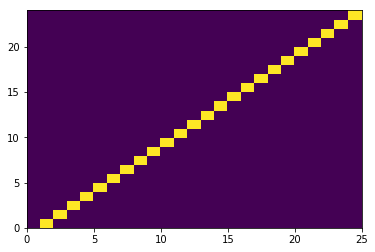

In [15]:
plt.pcolor(ex_4x6)